# Applying DeepLOB model to reproduce the prediction results of horizon 10 for FI - 2010 Dataset.

In [ ]:
# Importing the libraries.

import pandas as pd
import numpy as np
import keras
from keras.models import  Model
from keras.layers import  Dense, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation

In [ ]:
# Functions to prepare the data for the model.

def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = np_utils.to_categorical(y, 3)
    return x, y

In [ ]:
# Load the data and prepare the training, validation and test sets.
dec_data = np.loadtxt('Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

k = 0 # Which horizon to use for prediction
T = 100 # The input dimension (time steps)
n_hiddens = 64
checkpoint_filepath = './model_deeplob_k0/weights' # Where to save the model weights.

trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203701, 100, 40, 1) (203701, 3)
(50851, 100, 40, 1) (50851, 3)
(139488, 100, 40, 1) (139488, 3)


# Model Architecture

In [4]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(32, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(32, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(32, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

2024-08-06 11:56:03.111567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 16)  48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 16)  1040        ['leaky_re_lu[0][0]']        

/Users/lamprosganias/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=100, batch_size=32, verbose=1, callbacks=[model_checkpoint_callback,early_stopping])

Epoch 1/100
6366/6366 [==============================] - 466s 73ms/step - loss: 0.8475 - accuracy: 0.6289 - val_loss: 0.8454 - val_accuracy: 0.6361
Epoch 2/100
6366/6366 [==============================] - 474s 74ms/step - loss: 0.7443 - accuracy: 0.6843 - val_loss: 0.7780 - val_accuracy: 0.6709
Epoch 3/100
6366/6366 [==============================] - 475s 75ms/step - loss: 0.6703 - accuracy: 0.7352 - val_loss: 0.7284 - val_accuracy: 0.7018
Epoch 4/100
6366/6366 [==============================] - 478s 75ms/step - loss: 0.6484 - accuracy: 0.7447 - val_loss: 0.7175 - val_accuracy: 0.7081
Epoch 5/100
6366/6366 [==============================] - 479s 75ms/step - loss: 0.6361 - accuracy: 0.7493 - val_loss: 0.7115 - val_accuracy: 0.7103
Epoch 6/100
6366/6366 [==============================] - 485s 76ms/step - loss: 0.6276 - accuracy: 0.7525 - val_loss: 0.7321 - val_accuracy: 0.7096
Epoch 7/100
6366/6366 [==============================] - 481s 76ms/step - loss: 0.6212 - accuracy: 0.7548 - val_

# Model Testing

In [6]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

4359/4359 [==============================] - 109s 25ms/step


In [7]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.8261714269327828
              precision    recall  f1-score   support

           0     0.7423    0.5130    0.6067     21127
           1     0.8442    0.9586    0.8978     98602
           2     0.7647    0.5003    0.6049     19759

    accuracy                         0.8262    139488
   macro avg     0.7837    0.6573    0.7031    139488
weighted avg     0.8175    0.8262    0.8122    139488



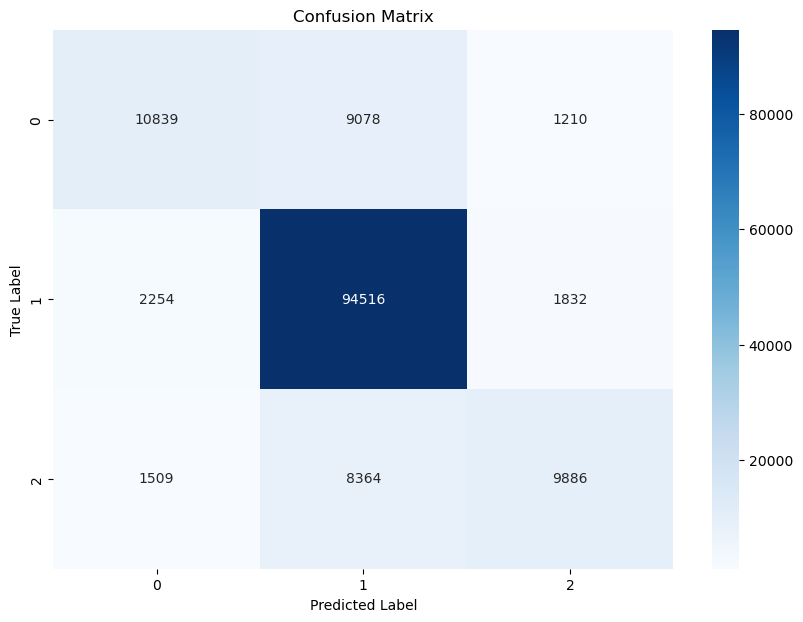

In [ ]:
# Convert one-hot encoded vectors to class labels
true_labels = np.argmax(testY_CNN, axis=1)
predicted_labels = np.argmax(pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()